# Imports

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import autokeras as ak

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")


Using TensorFlow backend


# Load datasets

In [2]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [3]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]

## Cleaning X

Found a hole in the X data on location A

1|2
---|---
![1](./feature_cleaning/img/X_A_1.png) | ![2](./feature_cleaning/img/X_A_2.png)

This prevents our aggregation method to match the target data after these data points

Trying to remove this point and reindex to fix the issue. 

In [4]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))

A: 
 136245
Int64Index([118664], dtype='int64')
136244


Same problem for B-set at `2022-05-02 23:00:00` and C-set at `2022-04-25 21:00:00`

In [5]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))

B: 
 134505
Int64Index([116916], dtype='int64')
134504
C: 
 134401
Int64Index([116244], dtype='int64')
134400


## Cleaning Y-data

`B` targets and `C` targets have lots of static values that seems like invalid data. 

Removing them with function below

[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

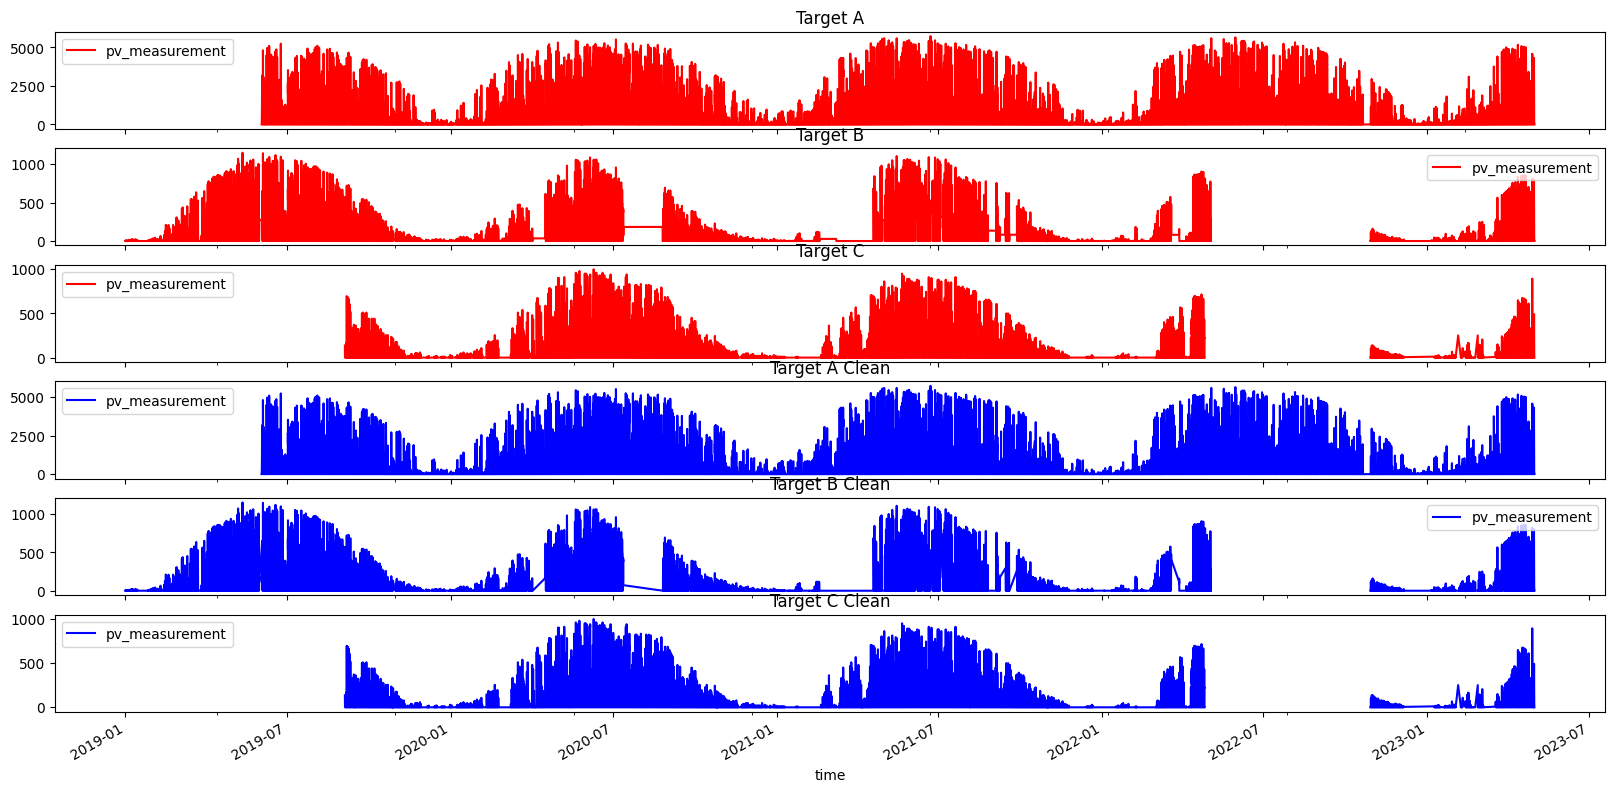

In [6]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [7]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])

In [8]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))

x,y:  34060 34060
x,y:  29596 29596
x,y:  26028 26028


In [9]:
# Verifying that all train dataset still have their end data after aggregation in case of allignment issue
for x in X_train:
    print(x["date_forecast"].tail())

34055   2023-04-30 19:00:00
34056   2023-04-30 20:00:00
34057   2023-04-30 21:00:00
34058   2023-04-30 22:00:00
34059   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[ns]
29591   2023-04-30 19:00:00
29592   2023-04-30 20:00:00
29593   2023-04-30 21:00:00
29594   2023-04-30 22:00:00
29595   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[ns]
26023   2023-04-30 19:00:00
26024   2023-04-30 20:00:00
26025   2023-04-30 21:00:00
26026   2023-04-30 22:00:00
26027   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[ns]


# Feature engineering

In [10]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
     temp = train.append(test, ignore_index = True)
     index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
     return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i].drop(columns=['date_forecast'], inplace=True)
     X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


/var/folders/94/wm45lcfj7sv746_0rnyvdk840000gn/T/ipykernel_69214/3188492942.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = train.append(test, ignore_index = True)
/var/folders/94/wm45lcfj7sv746_0rnyvdk840000gn/T/ipykernel_69214/3188492942.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = train.append(test, ignore_index = True)
/var/folders/94/wm45lcfj7sv746_0rnyvdk840000gn/T/ipykernel_69214/3188492942.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = train.append(test, ignore_index = True)


## Data Cleaning

In [11]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,6126,4588,5122
cloud_base_agl:m,2362,2025,2199
snow_density:kgm3,32920,28040,24561


In [12]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
precip_type_5min:idx_5,720,720,720


In [13]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)

## Dropping some suspicious data on A

In [14]:
drop_col = [
    'air_density_2m:kgm3',
    'ceiling_height_agl:m',
    'cloud_base_agl:m',
    'dew_point_2m:K',
    'visibility:m'
]
X_train[0].drop(columns=drop_col, inplace=True)
X_frames_test[0].drop(columns=drop_col, inplace=True)

In [15]:
import tensorflow as tf

normalizer_A = tf.keras.layers.Normalization(axis=-1)
normalizer_A.adapt(X_train[0])

first = np.array(X_train[0][:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer_A(first).numpy())

normalizer_B = tf.keras.layers.Normalization(axis=-1)
normalizer_B.adapt(X_train[1])
normalizer_C = tf.keras.layers.Normalization(axis=-1)
normalizer_C.adapt(X_train[2])

First example: [[   0.      1.      7.7     0.      0.      0.      0.      0.      0.
    99.07    0.      0.      0.      0.      0.   1006.3     0.    993.75
   999.78    0.      0.     71.67 1005.8     0.      0.      0.      0.17
   348.04   -3.77    0.    286.23  100.      3.6    -3.57   -0.5     0.
    -0.5     0.87    0.49   -0.87    0.      1.      0.      1.      0.
     0.      0.      0.  ]]

Normalized: [[-0.97  0.95  0.49 -0.65 -0.65 -0.67 -0.68 -0.46 -0.46  0.93 -0.15 -0.09
  -0.19 -0.1  -0.12 -0.26 -0.2  -0.23 -0.24 -0.08 -0.25 -0.17 -0.25 -0.16
   0.   -0.05  0.36  1.72 -0.15 -0.54  0.94  0.77  0.3  -1.46 -0.58 -0.01
  -0.71  1.22  0.71 -1.25 -0.09  0.19 -0.17  0.24 -0.21 -0.07 -0.08 -0.01]]


In [16]:
norm_a = normalizer_A(np.array(X_train[0])).numpy()
norm_b = normalizer_B(np.array(X_train[1])).numpy()
norm_c = normalizer_C(np.array(X_train[2])).numpy()

# Training the model

In [17]:
x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_train[0], Y_train[0], test_size=0.17, random_state=None)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_train[1], Y_train[1], test_size=0.17, random_state=None)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_train[2], Y_train[2], test_size=0.17, random_state=None)

In [18]:
model_a = ak.StructuredDataRegressor(
    overwrite=True,
    max_trials= 30,
    loss="mean_absolute_error",
    project_name="A_location"
)

model_a.fit(
    x = norm_a,
    y = Y_train[0],
    epochs=500
)

Trial 30 Complete [00h 01m 24s]
val_loss: 164.8597412109375

Best val_loss So Far: 150.68603515625
Total elapsed time: 00h 54m 33s


Epoch 1/500
1065/1065 [==============================] - 2s 1ms/step - loss: 301.2050 - mean_squared_error: 488772.3438
Epoch 2/500
1065/1065 [==============================] - 1s 1ms/step - loss: 211.9430 - mean_squared_error: 219054.8438
Epoch 3/500
1065/1065 [==============================] - 1s 1ms/step - loss: 207.9983 - mean_squared_error: 217154.3438
Epoch 4/500
1065/1065 [==============================] - 1s 1ms/step - loss: 205.2744 - mean_squared_error: 215226.2031
Epoch 5/500
1065/1065 [==============================] - 1s 1ms/step - loss: 203.1717 - mean_squared_error: 213652.8750
Epoch 6/500
1065/1065 [==============================] - 1s 1ms/step - loss: 201.3445 - mean_squared_error: 211798.2500
Epoch 7/500
1065/1065 [==============================] - 1s 1ms/step - loss: 199.8958 - mean_squared_error: 210247.1250
Epoch 8/500
1065/1065 [==============================] - 1s 1ms/step - loss: 198.5237 - mean_squared_error: 208422.1406
Epoch 9/500
1065/1065 [=================

INFO:tensorflow:Assets written to: ./A_location/best_model/assets


In [19]:
best_a = model_a.export_model()

In [20]:
best_a.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48)]              0         
                                                                 
 multi_category_encoding (M  (None, 48)                0         
 ultiCategoryEncoding)                                           
                                                                 
 normalization (Normalizati  (None, 48)                97        
 on)                                                             
                                                                 
 dense (Dense)               (None, 512)               25088     
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                8208  

In [22]:

layer_list = []
for i in range(8):
    layer = best_a.get_layer(index=i)
    layer_list.append(layer.get_config())

In [23]:
layer_list[2]

{'name': 'normalization',
 'trainable': True,
 'dtype': 'float32',
 'axis': (-1,),
 'invert': False,
 'mean': None,
 'variance': None}

In [24]:
best_a.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 48),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'registered_name': None,
   'name': 'input_1',
   'inbound_nodes': []},
  {'module': 'autokeras.keras_layers',
   'class_name': 'MultiCategoryEncoding',
   'config': {'name': 'multi_category_encoding',
    'trainable': True,
    'dtype': 'float32',
    'encoding': ['int',
     'int',
     'int',
     'none',
     'none',
     'none',
     'none',
     'none',
     'none',
     'none',
     'int',
     'int',
     'int',
     'int',
     'int',
     'none',
     'int',
     'none',
     'none',
     'int',
     'int',
     'none',
     'none',
     'int',
     'int',
     'int',
     'int',
     'none',
     'none',
     'int',
     'none',
     'none',
     'int',
     'int',
     'int',
     'int',
     'int',
     'int',
     'none',
     '

In [25]:
best_a.save(filepath='./tensorflow_models/best_a_02_11.keras')

In [26]:
model_b = ak.StructuredDataRegressor(
    overwrite=True,
    max_trials= 30,
    loss="mean_absolute_error",
    project_name="B_location"
)

model_b.fit(
    x = norm_b,
    y = Y_train[1],
    epochs=500
)

Trial 30 Complete [00h 00m 52s]
val_loss: 23.796703338623047

Best val_loss So Far: 23.796703338623047
Total elapsed time: 00h 46m 33s


Epoch 1/500
925/925 [==============================] - 1s 889us/step - loss: 94.4413 - mean_squared_error: 40040.3633
Epoch 2/500
925/925 [==============================] - 1s 905us/step - loss: 88.6617 - mean_squared_error: 40009.5898
Epoch 3/500
925/925 [==============================] - 1s 885us/step - loss: 76.1612 - mean_squared_error: 30158.5957
Epoch 4/500
925/925 [==============================] - 1s 890us/step - loss: 56.9074 - mean_squared_error: 17827.8945
Epoch 5/500
925/925 [==============================] - 1s 889us/step - loss: 44.8432 - mean_squared_error: 11213.2422
Epoch 6/500
925/925 [==============================] - 1s 897us/step - loss: 40.5664 - mean_squared_error: 9091.2656
Epoch 7/500
925/925 [==============================] - 1s 898us/step - loss: 39.3158 - mean_squared_error: 8637.0889
Epoch 8/500
925/925 [==============================] - 1s 885us/step - loss: 38.5826 - mean_squared_error: 8373.0781
Epoch 9/500
925/925 [==============================] - 1s 9

INFO:tensorflow:Assets written to: ./B_location/best_model/assets


In [27]:
best_b = model_b.export_model()
best_b.save(filepath='./tensorflow_models/best_b_02_11.keras')

In [28]:
model_c = ak.StructuredDataRegressor(
    overwrite=True,
    max_trials= 30,
    loss="mean_absolute_error",
    project_name="C_location"
)

history_c = model_c.fit(
    x = norm_c,
    y = Y_train[2],
    epochs=500
)

Trial 30 Complete [00h 00m 31s]
val_loss: 34.6453971862793

Best val_loss So Far: 18.584735870361328
Total elapsed time: 00h 26m 12s


Epoch 1/500
814/814 [==============================] - 2s 2ms/step - loss: 38.0803 - mean_squared_error: 8988.1865
Epoch 2/500
814/814 [==============================] - 2s 2ms/step - loss: 32.5559 - mean_squared_error: 6684.1885
Epoch 3/500
814/814 [==============================] - 2s 2ms/step - loss: 32.4828 - mean_squared_error: 6710.3115
Epoch 4/500
814/814 [==============================] - 2s 2ms/step - loss: 32.4390 - mean_squared_error: 6715.4746
Epoch 5/500
814/814 [==============================] - 2s 2ms/step - loss: 31.7825 - mean_squared_error: 6439.6016
Epoch 6/500
814/814 [==============================] - 2s 2ms/step - loss: 31.5157 - mean_squared_error: 6398.8218
Epoch 7/500
814/814 [==============================] - 2s 2ms/step - loss: 31.5775 - mean_squared_error: 6363.9663
Epoch 8/500
814/814 [==============================] - 2s 2ms/step - loss: 31.7381 - mean_squared_error: 6485.6567
Epoch 9/500
814/814 [==============================] - 2s 2ms/step - loss: 31.48

INFO:tensorflow:Assets written to: ./C_location/best_model/assets


In [29]:
best_c = model_c.export_model()
best_c.save(filepath='./tensorflow_models/best_c_02_11.keras')

# Make predictions

In [30]:
norm_ta = normalizer_A(np.array(X_frames_test[0])).numpy()
norm_tb = normalizer_B(np.array(X_frames_test[1])).numpy()
norm_tc = normalizer_C(np.array(X_frames_test[2])).numpy()

In [31]:
# Do some more stuff
y_a = best_a.predict(norm_ta)
y_b = best_b.predict(norm_tb)
y_c = best_c.predict(norm_tc)

23/23 [==============================] - 0s 1ms/step


In [32]:
y_pred = np.concatenate((y_a, y_b, y_c), axis=0)

In [33]:
print(y_pred)

[[-2.1305452e-05]
 [-2.1305452e-05]
 [-2.1305452e-05]
 ...
 [ 3.1219082e-04]
 [ 3.1219082e-04]
 [ 3.1219082e-04]]


# Create submission

In [35]:
for i in range(len(y_pred)):
    if y_pred[i] < 0: 
        y_pred[i] = 0
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_ak_2.csv', index=False)

In [38]:
#combine submission
res = []
comb = pd.read_csv("../best_notebooks/submissions/submission_xg.csv")
for i in range(len(comb)):
    res.append((comb["prediction"].iloc[i] + submission["prediction"].iloc[i])/2)

new_sub = pd.DataFrame()
new_sub["id"] = submission["id"]
new_sub["prediction"] = res

new_sub.to_csv("./submissions/sub_combined_xg_ak.csv", index = False)